This script will attempt to process and plot echosounder and amplitude Data as a means of understanding sediment characteristics. This deployment ended on 9/19/25 12:00.

In [4]:
### Code to read in h5 files as detailed in the first guidebook
# Import necessary packages
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.io import loadmat
import datetime as dt

In [5]:
deployment_num = 1
sensor_id = "E1_103071"
# directory_initial_user_path = r"/Volumes/BOEM/"  # Katherine
# directory_initial_user_path = r"/Volumes/kanarde/BOEM/"  # Brooke
directory_initial_user_path = r"Z:/"  # Levi

In [6]:
# Import seabird data
sbepath = "Z:\deployment_1\Raw\E1RBR\SBE_00003570_DEP4_FPSE1_L0.mat"
stuff = loadmat(
    sbepath
)  # Load mat oragnizes the 4 different data structures of the .mat file (Units, Config, Data, Description) as a
# dictionary with four nested numpy arrays with dtypes as data field titles
sbe = {}
for names in stuff.keys():
    sbe[names] = stuff[
        names
    ]  # Convert the numpy arrays to a dictionary with the data field titles as keys
    print(names)
del stuff

__header__
__version__
__globals__
SN
time
conductivity
temperature
pressure
salinity
units
notes


In [7]:
# Create dictionary for each sensor
dirpath = os.path.join(
    directory_initial_user_path,
    f"deployment_{deployment_num}/Processed/",
    f"{sensor_id}",
    "Group36",
)  # path to the directory containing the h5 files
files = os.listdir(dirpath)  # list of files for the sensor
Data = {}
for file in files:
    file_path = os.path.join(dirpath, file)  # file path
    df = pd.read_hdf(file_path)  # read the file into a Pandas Dataframe
    file_name = file.split(".")[0]  # file name
    print(file_name)
    Data[file_name] = df  # store Dataframe
globals()[f"Data_{sensor_id}"] = Data

AbsVel
Time
EastVel
NorthVel
VertVel
ErrVel
Heading
Roll
Pitch
Pressure
VelBeamCorr1
VelBeamCorr2
VelBeamCorr3
VelBeamCorr4
CellDepth
Echo1
Echo2
CellDepth_echo
AmpBeam1
AmpBeam2
AmpBeam3
AmpBeam4
VbAmplitude


In [8]:
filepath = os.path.join(
    directory_initial_user_path,
    f"deployment_{deployment_num}/BulkStats/",
    f"{sensor_id}",
)
files = os.listdir(filepath)  # list of files for the sensor
waves = {}
for file in files:
    file_path = os.path.join(filepath, file)  # file path
    df = pd.read_hdf(file_path)  # read the file into a Pandas Dataframe
    file_name = file.split(".")[0]  # file name
    print(file_name)
    waves[file_name] = df  # store Dataframe
globals()[f"waves_{sensor_id}"] = waves

GroupSpeed
Frequencies
WaveNumbers
Time
WaveCelerity
MeanPeriod
SignificantWaveHeight
DepthAveragedEastVelocity
DepthAveragedNorthVelocity
DepthAveragedUpVelocity
DepthAveragedCurrentVelocity
MeanDirection1
MeanSpread1
MeanDirection2
MeanSpread2
DepthAveragedFlowDirection
PressureSpectra
PressureEastVelCospectra
PressureNorthVelCospectra
EastVelSpectra
NorthVelSpectra
VolumetricBackscatter1
Echo1avg
Echo2avg
Vertavg
SedTime
TargetStrength
BottomhalfScatterersavg
TophalfScatterersavg
TopVolumetricBackscatter1
BotVolumetricBackscatter1
Pressure


In [9]:
"""This section will test calculate target strength"""


# Attempts at sediment attentuation of the amplitude data, at the start are the required parameters for calculation
def sediment_analysis(Echo, S, T, P, CellDepth_echo, Burst_Pressure, transmit_length):

    ph = 8.1
    freq = 1000  # kHz
    transmit_power = 0
    beam_angle = 0.015
    Csv = 0
    transmit_length_sec = transmit_length / 1000

    # Convert to arrays
    echo_array = Echo.values
    ranges = CellDepth_echo.values.flatten()  # shape (n_cells,)
    n_samples, n_cells = echo_array.shape

    # build depth matrix
    pressures = Burst_Pressure.values.flatten()  # shape (n_samples,)
    depths_matrix = pressures[:, None] - ranges[None, :]  # shape (n_samples, n_cells)
    depths_matrix[depths_matrix <= 0] = 0

    range_matrix = np.tile(ranges, (n_samples, 1))  # shape (n_samples, n_cells)

    T0 = float(np.nanmean(T))
    S0 = float(np.nanmean(S))

    # Sound speed
    soundspeed = (
        1448.96 + 4.591 * T0 - 5.304e-2 * T0**2 + 2.374e-4 * T0**3 + 1.34 * (S0 - 35)
    )

    # Attenuation coefficients
    A_1 = (8.66 * 10 ** (0.78 * ph - 5)) / soundspeed
    A_2 = (21.44 * S0 * (1 + 0.025 * T0)) / soundspeed
    f_1 = 2.8 * np.sqrt(S0 / 35) * 10 ** (4 - 1245 / (T0 + 273))
    f_2 = (8.17 * 10 ** (8 - (1990 / (T0 + 273)))) / (1 + 0.0018 * (S0 - 35))

    P_2 = 1 - 1.37e-4 * depths_matrix + 6.2e-9 * depths_matrix**2
    P_3 = 1 - 3.83e-5 * depths_matrix + 4.9e-10 * depths_matrix**2

    if T0 <= 20:
        A_3 = 4.937e-4 - 2.59e-5 * T0 + 3.2e-7 * T0**2 - 1.5e-8 * T0**3
    else:
        A_3 = 3.964e-4 - 1.146e-5 * T0 + 1.45e-7 * T0**2 - 6.5e-10 * T0**3

    # absorption, shape: (n_samples, n_cells)
    a_w = (freq**2) * (
        ((A_1 * f_1) / (f_1**2 + freq**2))
        + ((A_2 * P_2 * f_2) / (f_2**2 + freq**2))
        + A_3 * P_3
    )
    a_w /= 1000  # dB/m

    # Sv calculation
    Sv = (
        echo_array * 0.43
        + 20 * np.log10(range_matrix)
        + 2 * a_w * range_matrix
        + transmit_power
        - 10 * np.log10((soundspeed * transmit_length_sec) / 2)
        - beam_angle
        + Csv
    )

    print(
        "Look at magnitudes",
        20 * np.log10(range_matrix).max(),
        a_w.max(),
        np.nanmax(echo_array * 0.43),
    )

    # TS calculation
    TS = (
        echo_array * 0.43
        + 40 * np.log10(10 * range_matrix)
        + 2 * a_w * range_matrix
        + transmit_power
    )

    # Convert back to DataFrames
    Sv_df = pd.DataFrame(Sv, index=Echo.index, columns=Echo.columns)
    TS_df = pd.DataFrame(TS, index=Echo.index, columns=Echo.columns)

    # mean echo amplitude
    echoavg = Echo.mean(axis=1)

    return echoavg, Sv_df, TS_df, depths_matrix


Echo1avg, S_v1, TS, depths_matrix = sediment_analysis(
    Data["Echo1"],
    sbe["salinity"],
    sbe["temperature"],
    sbe["pressure"],
    Data["CellDepth_echo"],
    Data["Pressure"],
    0.330,
)

Echo2avg, S_v2, ___, ___ = sediment_analysis(
    Data["Echo2"],
    sbe["salinity"],
    sbe["temperature"],
    sbe["pressure"],
    Data["CellDepth_echo"],
    Data["Pressure"],
    0.033,
)

Look at magnitudes 23.722167725693946 0.32593752906287954 35.4664
Look at magnitudes 23.722167725693946 0.32593752906287954 49.4887


C:\Users\lwlav\AppData\Local\Temp\ipykernel_28040\3717704215.py:38: RuntimeWarning: Mean of empty slice
  (S_v1 - np.nanmean(S_v1, axis=0)).T,


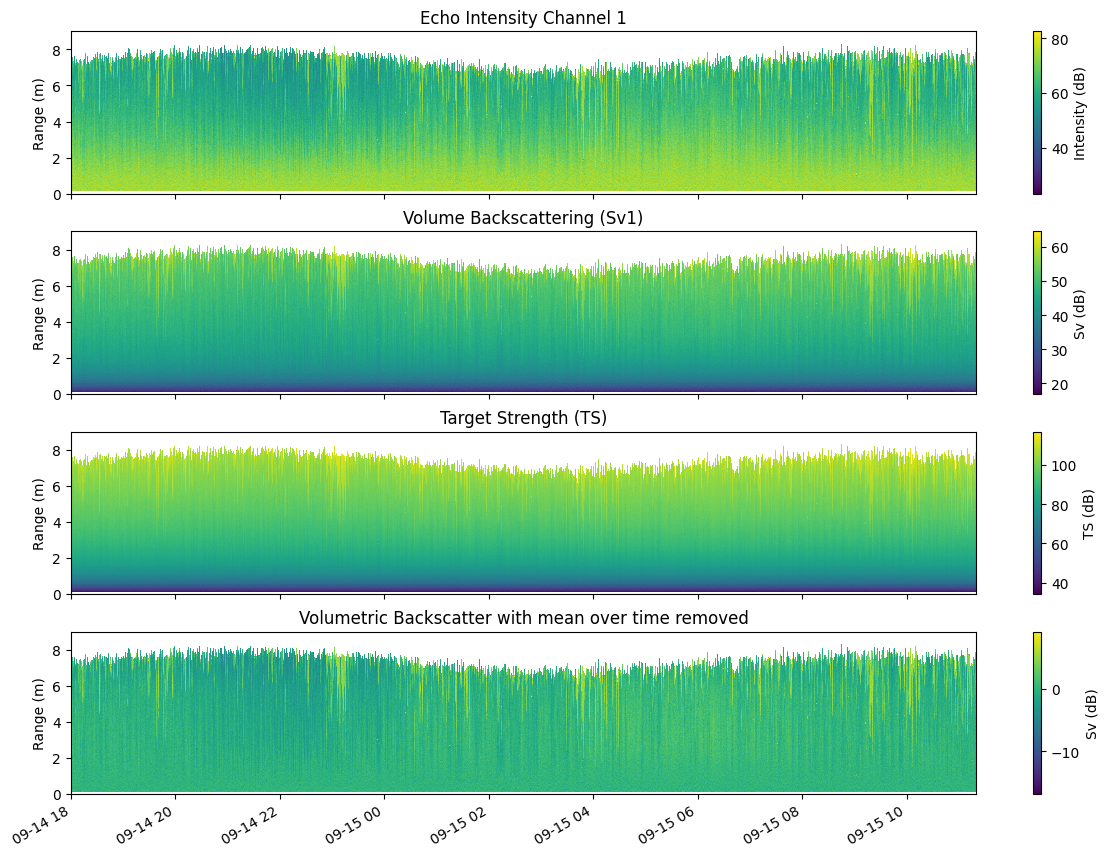

In [10]:
"""This section will generate plots to look at echosounder backscatter and target strength"""

fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plot 1: Echo1
pcm0 = axs[0].pcolormesh(
    Data["Time"][0],
    Data["CellDepth_echo"],
    Data["Echo1"].T,
    shading="auto",
    cmap="viridis",
)
axs[0].set_title("Echo Intensity Channel 1")
axs[0].set_ylabel("Range (m)")
cbar0 = fig.colorbar(pcm0, ax=axs[0], orientation="vertical")
cbar0.set_label("Intensity (dB)")

# Plot 2: S_v1
pcm1 = axs[1].pcolormesh(
    Data["Time"][0], Data["CellDepth_echo"], S_v1.T, shading="auto"
)
axs[1].set_title("Volume Backscattering (Sv1)")
axs[1].set_ylabel("Range (m)")
cbar1 = fig.colorbar(pcm1, ax=axs[1], orientation="vertical")
cbar1.set_label("Sv (dB)")

# Plot 3: TS
pcm2 = axs[2].pcolormesh(Data["Time"][0], Data["CellDepth_echo"], TS.T, shading="auto")
axs[2].set_title("Target Strength (TS)")
axs[2].set_ylabel("Range (m)")
cbar2 = fig.colorbar(pcm2, ax=axs[2], orientation="vertical")
cbar2.set_label("TS (dB)")

# Plot 4: Optional – leave blank or add another variable
pcm3 = axs[3].pcolormesh(
    Data["Time"][0],
    Data["CellDepth_echo"],
    (S_v1 - np.nanmean(S_v1, axis=0)).T,
    shading="auto",
)
axs[3].set_title("Volumetric Backscatter with mean over time removed")
axs[3].set_ylabel("Range (m)")
cbar3 = fig.colorbar(pcm3, ax=axs[3], orientation="vertical")
cbar3.set_label("Sv (dB)")


for ax in axs:
    ax.set_ylim(0, 9)
# General layout tweaks
plt.tight_layout()
fig.autofmt_xdate(rotation=30)

# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\E1_closelookatwaves_.png")

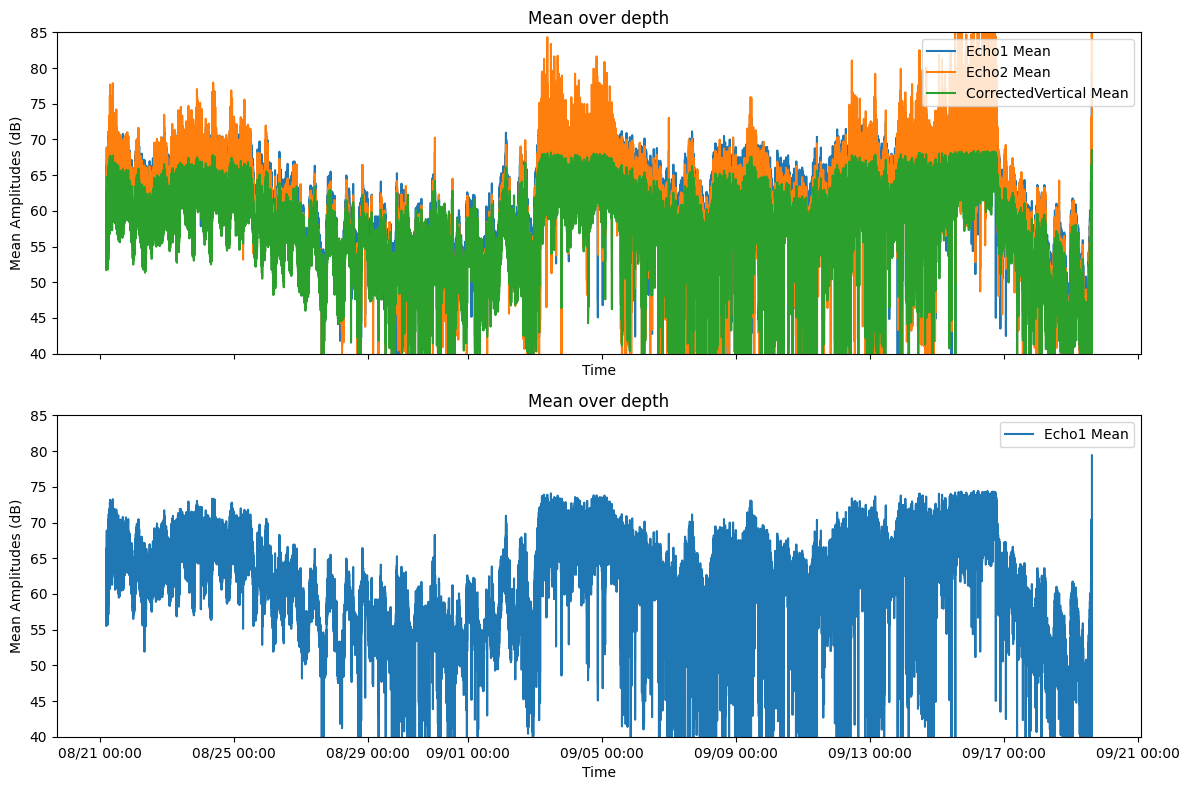

In [11]:
# Integrated and avg backscatter over depth bins (you have to avg the echosounder to same bin size as vertbeam first)
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(waves["SedTime"], waves["Echo1avg"], label="Echo1 Mean")
axs[0].plot(waves["SedTime"], waves["Echo2avg"], label="Echo2 Mean")
axs[0].plot(waves["SedTime"], waves["Vertavg"] - 17, label="CorrectedVertical Mean")
axs[0].set_title("Mean over depth")
axs[0].set_ylabel("Mean Amplitudes (dB)")
axs[0].set_xlabel("Time")
axs[0].set_ylim(40, 85)
axs[0].legend(loc = 'upper right')

axs[1].plot(waves["SedTime"], waves["Echo1avg"], label="Echo1 Mean")
axs[1].set_title("Mean over depth")
axs[1].set_ylabel("Mean Amplitudes (dB)")
axs[1].set_xlabel("Time")
axs[1].set_ylim(40, 85)
axs[1].legend(loc = 'upper right')



for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
plt.tight_layout()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_backscatter_.png")

**This section will look at the two different scatterer halfs**

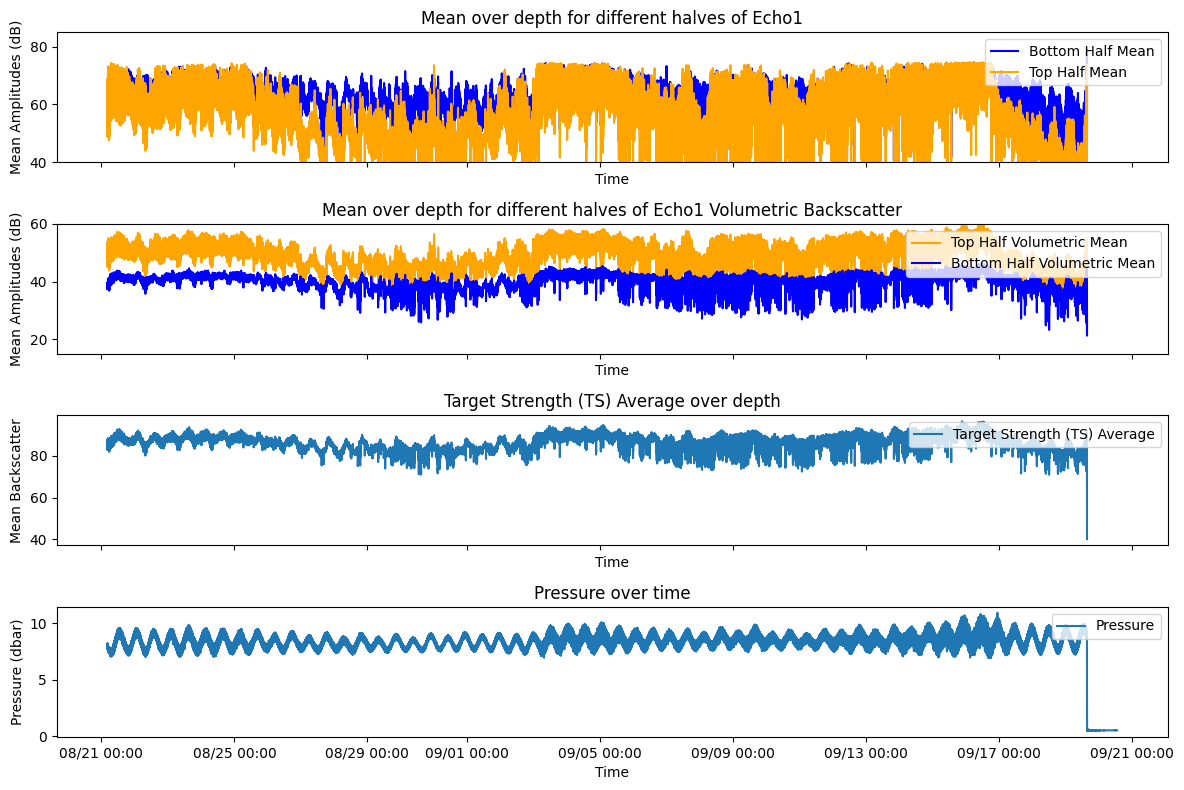

In [12]:
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)


axs[0].plot(
    waves["SedTime"],
    waves["BottomhalfScatterersavg"],
    label="Bottom Half Mean",
    color="blue",
)
axs[0].plot(
    waves["SedTime"],
    waves["TophalfScatterersavg"],
    label="Top Half Mean",
    color="orange",
)
axs[0].set_title("Mean over depth for different halves of Echo1")
axs[0].set_ylabel("Mean Amplitudes (dB)")
axs[0].set_xlabel("Time")
axs[0].set_ylim(40, 85)
axs[0].legend(loc="upper right")

axs[1].plot(
    waves["SedTime"],
    waves["TopVolumetricBackscatter1"],
    label="Top Half Volumetric Mean",
    color="orange",
)
axs[1].plot(
    waves["SedTime"],
    waves["BotVolumetricBackscatter1"],
    label="Bottom Half Volumetric Mean",
    color="blue",
)
axs[1].set_title("Mean over depth for different halves of Echo1 Volumetric Backscatter")
axs[1].set_ylabel("Mean Amplitudes (dB)")
axs[1].set_xlabel("Time")
axs[1].set_ylim(15, 60)
axs[1].legend(loc="upper right")

axs[2].plot(
    waves["SedTime"],
    waves["TargetStrength"],
    label="Target Strength (TS) Average",
)
axs[2].set_title("Target Strength (TS) Average over depth")
axs[2].set_ylabel("Mean Backscatter")
axs[2].set_xlabel("Time")
axs[2].legend(loc="upper right")

axs[3].plot(waves["SedTime"], waves["Pressure"], label="Pressure")
axs[3].set_title("Pressure over time")
axs[3].set_ylabel("Pressure (dbar)")
axs[3].set_xlabel("Time")
axs[3].legend(loc="upper right")


for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
plt.tight_layout()
# plt.savefig(
    # f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_halvsies_.png"
# )

**This section will look at major events and as well as calm periods in the signals**

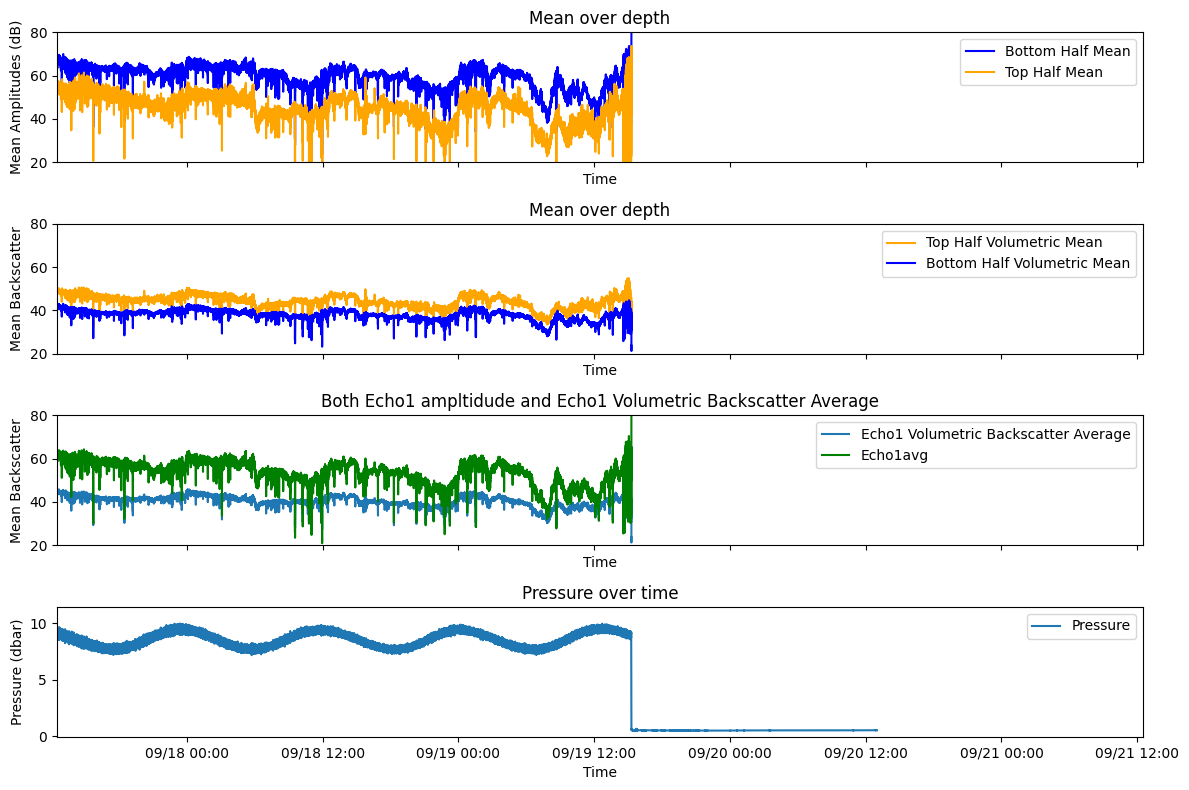

In [13]:
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axs[0].plot(
    waves["SedTime"],
    waves["BottomhalfScatterersavg"],
    label="Bottom Half Mean",
    color="blue",
)
axs[0].plot(
    waves["SedTime"],
    waves["TophalfScatterersavg"],
    label="Top Half Mean",
    color="orange",
)
axs[0].set_title("Mean over depth")
axs[0].set_ylabel("Mean Amplitudes (dB)")
axs[0].set_xlabel("Time")
axs[0].set_ylim(20, 80)
axs[0].legend(loc="upper right")

axs[1].plot(
    waves["SedTime"],
    waves["TopVolumetricBackscatter1"],
    label="Top Half Volumetric Mean",
    color="orange",
)
axs[1].plot(
    waves["SedTime"],
    waves["BotVolumetricBackscatter1"],
    label="Bottom Half Volumetric Mean",
    color="blue",
)
axs[1].set_title("Mean over depth")
axs[1].set_ylabel("Mean Backscatter")
axs[1].set_xlabel("Time")
axs[1].set_ylim(20, 80)
axs[1].legend(loc="upper right")

axs[2].plot(
    waves["SedTime"],
    waves["VolumetricBackscatter1"],
    label="Echo1 Volumetric Backscatter Average",
)
axs[2].plot(waves["SedTime"], waves["Echo1avg"], label="Echo1avg", color="green")
axs[2].set_title("Both Echo1 ampltidude and Echo1 Volumetric Backscatter Average")
axs[2].set_ylabel("Mean Backscatter")
axs[2].set_xlabel("Time")
axs[2].legend(loc="upper right")
axs[2].set_ylim(20, 80)

axs[3].plot(waves["SedTime"], waves['Pressure'], label="Pressure")
axs[3].set_title("Pressure over time")
axs[3].set_ylabel("Pressure (dbar)")
axs[3].set_xlabel("Time")
axs[3].legend(loc="upper right")


for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
    ax.set_xlim(
        datetime.datetime(2024, 9, 17, 12, 30), datetime.datetime(2024, 9, 21, 12, 30)
    )
plt.tight_layout()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_TC8_.png")

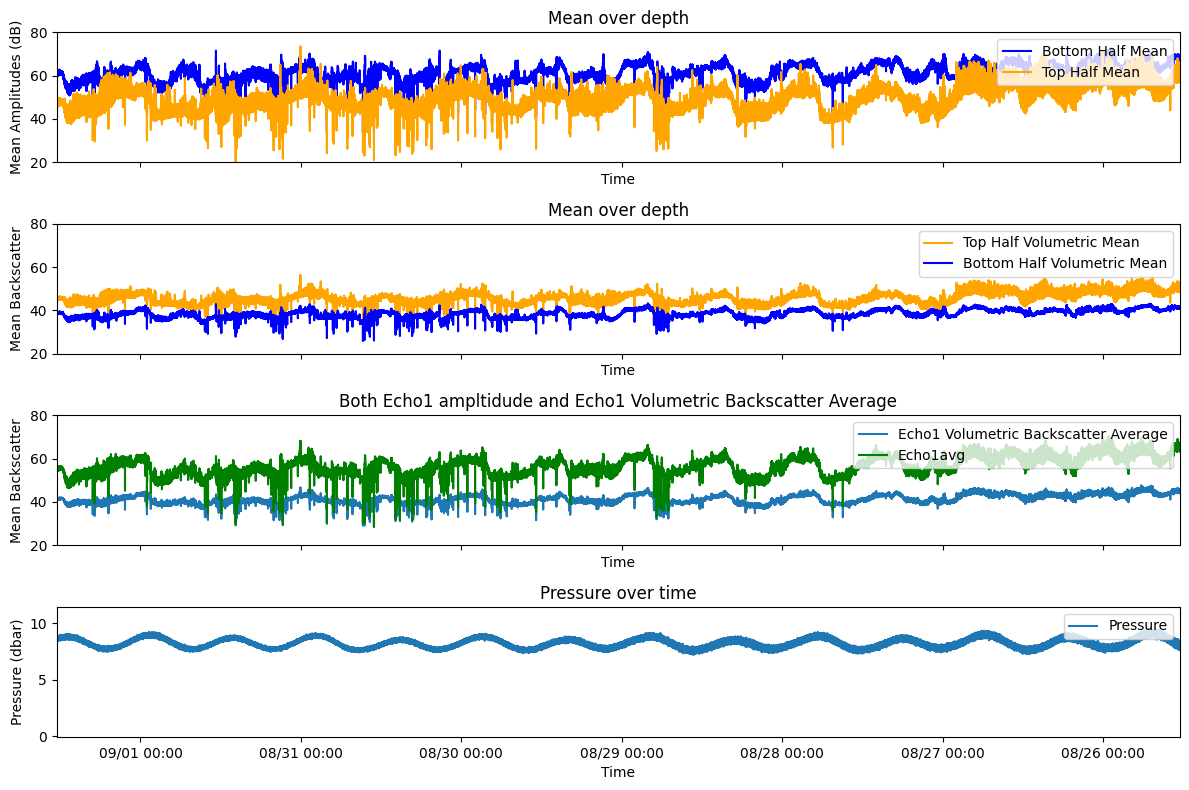

In [14]:
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)


axs[0].plot(
    waves["SedTime"],
    waves["BottomhalfScatterersavg"],
    label="Bottom Half Mean",
    color="blue",
)
axs[0].plot(
    waves["SedTime"],
    waves["TophalfScatterersavg"],
    label="Top Half Mean",
    color="orange",
)
axs[0].set_title("Mean over depth")
axs[0].set_ylabel("Mean Amplitudes (dB)")
axs[0].set_xlabel("Time")
axs[0].set_ylim(20, 80)
axs[0].legend(loc="upper right")

axs[1].plot(
    waves["SedTime"],
    waves["TopVolumetricBackscatter1"],
    label="Top Half Volumetric Mean",
    color="orange",
)
axs[1].plot(
    waves["SedTime"],
    waves["BotVolumetricBackscatter1"],
    label="Bottom Half Volumetric Mean",
    color="blue",
)
axs[1].set_title("Mean over depth")
axs[1].set_ylabel("Mean Backscatter")
axs[1].set_xlabel("Time")
axs[1].set_ylim(20, 80)
axs[1].legend(loc="upper right")

axs[2].plot(
    waves["SedTime"],
    waves["VolumetricBackscatter1"],
    label="Echo1 Volumetric Backscatter Average",
)
axs[2].plot(waves["SedTime"], waves["Echo1avg"], label="Echo1avg", color="green")
axs[2].set_title("Both Echo1 ampltidude and Echo1 Volumetric Backscatter Average")
axs[2].set_ylabel("Mean Backscatter")
axs[2].set_xlabel("Time")
axs[2].legend(loc="upper right")
axs[2].set_ylim(20, 80)

axs[3].plot(waves["SedTime"], waves['Pressure'], label="Pressure")
axs[3].set_title("Pressure over time")
axs[3].set_ylabel("Pressure (dbar)")
axs[3].set_xlabel("Time")
axs[3].legend(loc="upper right")


for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
    ax.set_xlim(
        datetime.datetime(2024, 9, 1, 12, 30), datetime.datetime(2024, 8, 25, 12, 30)
    )
plt.tight_layout()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_TC8_.png")

***This section will perform some analyses on Vertical Beam and Echosounder***

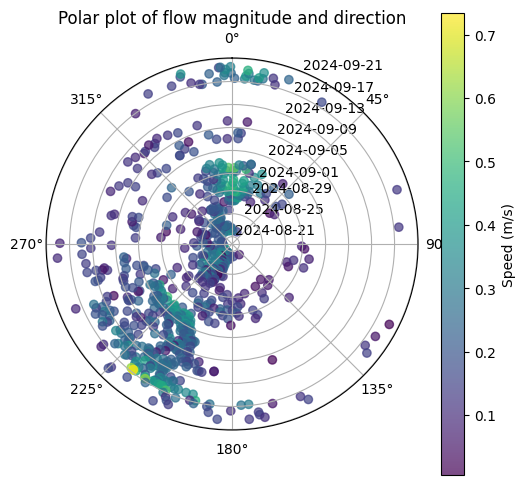

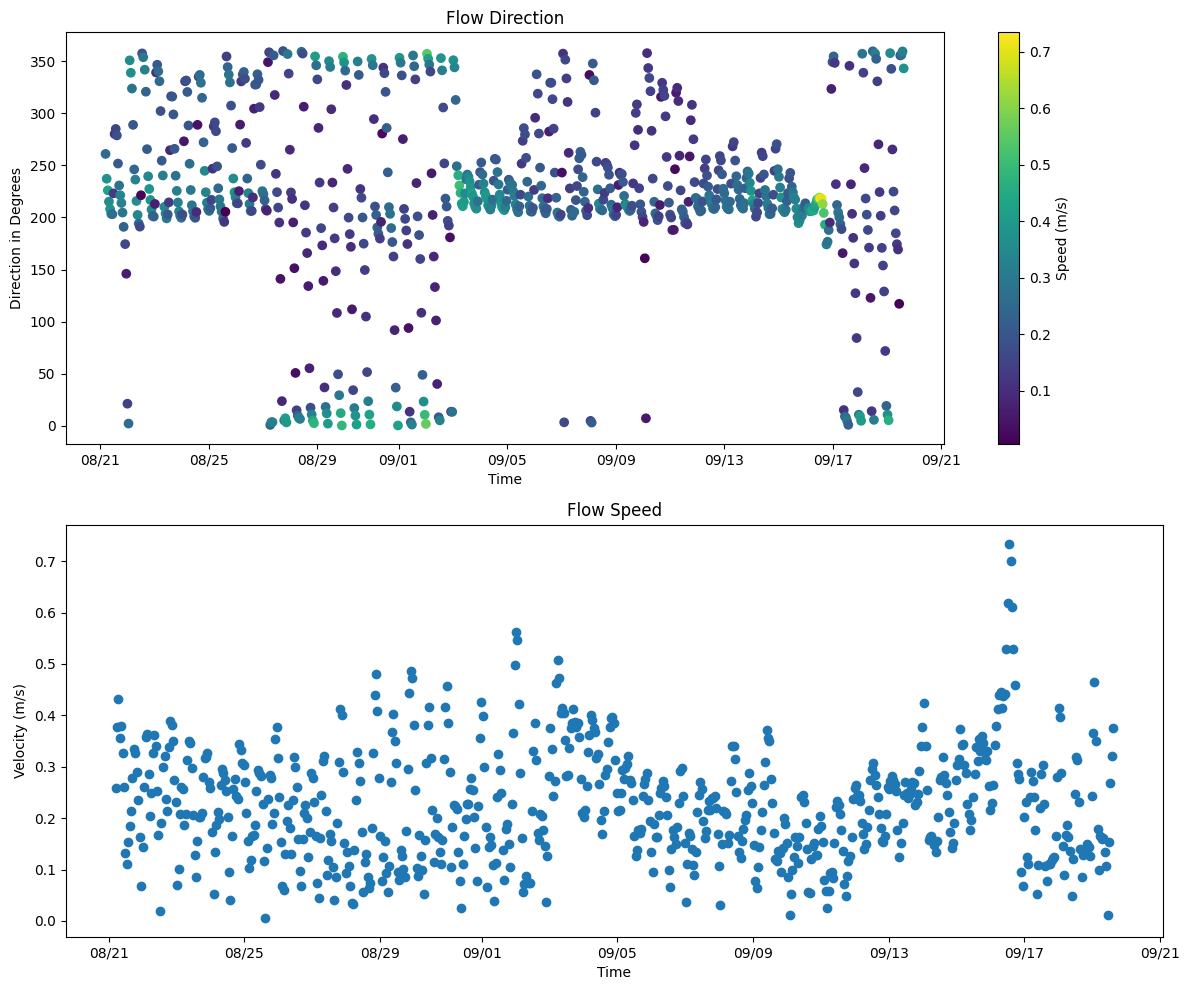

In [15]:
# Orbital plot to look at flow direction


# Convert to radians
speed = waves["DepthAveragedCurrentVelocity"]

dir_rad = np.deg2rad(waves["DepthAveragedFlowDirection"])

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
sc = ax.scatter(dir_rad, waves["Time"].values, c=speed, cmap="viridis", alpha=0.7)

ax.set_theta_zero_location("N")  # set 0° at north
ax.set_theta_direction(-1)  # clockwise
plt.title("Polar plot of flow magnitude and direction")
plt.colorbar(sc, label="Speed (m/s)")
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_polarflowdir.png")

figs, axs = plt.subplots(2, 1, figsize=(12, 10))
gg = axs[0].scatter(waves["Time"].values, waves["DepthAveragedFlowDirection"], c=speed)
plt.colorbar(gg, label="Speed (m/s)")
axs[0].set_title("Flow Direction")
axs[0].set_ylabel("Direction in Degrees")
axs[0].set_xlabel("Time")
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
plt.tight_layout()

gg1 = axs[1].scatter(waves["Time"].values, waves["DepthAveragedCurrentVelocity"])
axs[1].set_ylabel("Velocity (m/s)")
axs[1].set_xlabel("Time")
axs[1].set_title("Flow Speed")
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
plt.tight_layout()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_flowdir.png")

In [115]:
###This script will use despiked data to calculate sediment statistics using spectral analysis.

import numpy as np
import pandas as pd
import scipy.signal as sig


def welch_method(data, dt, M, overlap):
    """
    Estimates the power spectral density (PSD) of 'data' using Welch's method.

    :param:
    data: ndarray
        Input time-series data as numpy array (shape: [samples, bins])
    dt: float
        Sampling time interval (seconds)
    M: int
        Number of subwindows
    overlap: float
        Fractional overlap between windows (0 <= overlap < 1)

    :return:
    psd: ndarray
        Welch's estimate of the power spectral density (units are [data^2]/Hz)
    frequency: ndarray
        Frequency array (Hz)

    """

    # Size of the input data
    sd = data.shape
    Ns = int(
        np.floor(sd[0] / (M - (M - 1) * overlap))
    )  # Number of samples in each chunk
    M = int(M)  # Ensure M is an integer
    ds = int(np.floor(Ns * (1 - overlap)))  # Number of indices to shift by in the loop
    ii = np.arange(Ns)  # Indices for each chunk

    # Hanning window
    win = np.hanning(Ns)
    win = np.tile(win, (sd[1], 1)).T  # Apply to all channels

    # Check if Ns is even or odd
    if Ns % 2 == 0:
        inyq = 1  # Don't double the Nyquist frequency
        stop = Ns // 2 + 1
    else:
        inyq = 0
        stop = (Ns + 1) // 2

    # Frequency vector
    frequency = np.arange(0, stop) / (dt * Ns)

    # Initialize the PSD estimate
    SX = np.zeros((stop, sd[1]))

    for m in range(M):
        inds = ii + (m) * ds  # Indices in the current block
        x = data[inds, :]  # Data from this block
        s2i = np.var(x, axis=0)  # Input variance

        x = x - np.nanmean(x)
        x = sig.detrend(x, axis=0, type="linear")
        x = win * x
        s2f = np.var(x, axis=0)  # Reduced variance
        s2f[s2f == 0] = 1e-10  # Prevent division by zero just in case

        # Apply scaling factor
        # x = np.sqrt(s2i / s2f) * x

        # FFT
        X = np.fft.fft(x, axis=0)
        X = X[:stop, :]  # Keep only positive frequencies
        A2 = np.abs(X) ** 2  # Amplitude squared
        A2[
            1:-inyq, :
        ] *= 2  # Double the amplitude for positive frequencies (except Nyquist)

        SX += A2
    
    #Correct for the windo reducing the power
    U = (win**2).mean(axis=0)  # mean square of window
    psd = SX * dt / (M * Ns * U)

    return psd, frequency


def waveNumber_dispersion(fr_rad, depth):
    """
    Calculates the wavenumber iteratively using the dispersion relationship and an initial guess of a deep water wave.

    :param:
    fr_rad: scalar or array
        wave frequency in radians
    depth: scalar
        mean water depth in m

    :return:
    k: scalar or array
        wavenumber in m^-1

    """
    g = 9.81  # (m/s^2) gravitational constant
    errortol = 0.001  # error tolerance

    # Ensure fr_rad is an array
    fr_rad = np.atleast_1d(fr_rad)

    # Initialize an array for k (same shape as fr_rad)
    k = np.zeros_like(fr_rad)

    # loop over frequency array
    for idx, fr in enumerate(fr_rad):
        err = 10
        ct = 0
        T = (2 * np.pi) / fr  # wave period
        L_0 = ((T**2) * g) / (2 * np.pi)  # deep water wave length
        kguess = (
            2 * np.pi
        ) / L_0  # initial guess of wave number as deep water wave number
        while err > errortol and ct < 1000:
            ct = ct + 1
            argument = kguess * depth
            k[idx] = (fr**2) / (
                g * np.tanh(argument)
            )  # calculate k with dispersion relationship
            err = abs(k[idx] - kguess)  # check for error
            kguess = k[idx]  # update k guess and repeat

    return k


def welch_cospec(datax, datay, dt, M, overlap):
    """
    Estimates the power cospectral density of 'data' using Welch's method.

    :param:
    datax: ndarray
        Input time-series data as numpy array (shape: [samples, bins])
    datay: ndarray
        Input second time-series data to compute cospectra with as numpy array (shape: [samples,bins])
    dt: float
        Sampling time interval (seconds)
    M: int
        Number of subwindows
    overlap: float
        Fractional overlap between windows (0 <= overlap < 1)

    :return:
    CoSP: ndarray
        Welch's estimate of the cospectral density (units are [data^2]/Hz -- real component)
    frequency: ndarray
        Frequency array (Hz)
    QuSP: ndarray
        quadrature (units are [data^2]/Hz -- imaginary component)
    COH: ndarray
        magnitude squared coherence
    PHI: ndarray
        phase (radians)

    """

    # Size of the input data
    sd = datax.shape
    Ns = int(
        np.floor(sd[0] / (M - (M - 1) * overlap))
    )  # Number of samples in each chunk
    M = int(M)  # Ensure M is an integer
    ds = int(np.floor(Ns * (1 - overlap)))  # Number of indices to shift by in the loop
    ii = np.arange(Ns)  # Indices for each chunk

    # Hanning window
    win = np.hanning(Ns)
    win = np.tile(win, (sd[1], 1)).T  # Apply to all channels

    # Check if Ns is even or odd
    if Ns % 2 == 0:
        inyq = 1  # Don't double the Nyquist frequency
        stop = Ns // 2 + 1
    else:
        inyq = 0
        stop = (Ns + 1) // 2

    # Frequency vector
    frequency = np.arange(0, stop) / (dt * Ns)

    # Initialize spectras
    Sxx = np.zeros((stop, sd[1]))
    Syy = np.zeros((stop, sd[1]))
    Cxy = np.zeros(
        (
            stop,
            sd[1],
        ),
        dtype=complex,
    )

    # Loop through chunks
    for m in range(M):
        inds = ii + (m - 1) * ds
        x = datax[inds, :]  # Acquire data in this chunk
        y = datay[inds, :]
        sx2i = np.var(x, axis=0)  # Find variance
        sy2i = np.var(y, axis=0)
        x = win * (x - np.mean(x, axis=0))  # Detrend and apply window
        y = win * (y - np.mean(y, axis=0))  # Detrend and apply window
        sx2f = np.var(x)  # Reduced Variance
        sy2f = np.var(y)  # Reduced Variance
        if sx2f == 0:
            sx2f = 1e-10
        if sy2f == 0:
            sy2f = 1e-10

        # Apply scaling factor
        x = np.sqrt(sx2i / sx2f) * x
        y = np.sqrt(sy2i / sy2f) * y

        # Take the fft of the data
        X = np.fft.fft(x, axis=0)[:stop, :]
        Y = np.fft.fft(y, axis=0)[:stop, :]

        # # Take the magnitude squared
        # Axx = np.abs(X) ** 2
        # Ayy = np.abs(Y) ** 2
        # Axy = np.abs(Y) ** 2

        # Double the amplitude for positive frequencies (except Nyquist)
        Axx = X * np.conj(X)
        Axx[1:-inyq, :] *= 2
        Ayy = Y * np.conj(Y)
        Ayy[1:-inyq, :] *= 2
        Axy = X * np.conj(Y)
        Axy[1:-inyq, :] *= 2

        # Combine the spectra for each chunk
        Sxx += Axx.real
        Syy += Ayy.real
        Cxy += Axy

    Sxx *= dt / (M * Ns)
    Syy *= dt / (M * Ns)
    Cxy *= dt / (M * Ns)

    # Take the cospectra as the real component (quadrature as imaginary) and calculated the magnitude squared coherence
    # and phase
    CoSP = np.real(Cxy)
    QuSP = np.imag(Cxy)
    # COH = abs(Cxy) / np.sqrt(Sxx * Syy)  # KA: giving invalid numbers in divide
    PHI = np.arctan2(-QuSP, CoSP)

    return CoSP, frequency, QuSP, PHI


def check_psd_variance(chunk, fs, M, overlap, welch_func, rtol=0.05):
    """
    chunk: ndarray [samples, channels]
    fs: sampling frequency (Hz)
    welch_func: function that returns (psd, freq)
    Returns ratio = var_spec / var_time
    """
    dt = 1.0 / fs

    psd, freq = welch_func(chunk, dt, M, overlap)
    df = freq[1] - freq[0]
    
    chunknomean = chunk - np.nanmean(chunk)
    chunk = sig.detrend(chunknomean,axis=0, type='linear')

    var_time = np.var(chunk, axis=0)
    var_spec = np.sum(psd, axis=0) * df

    # return ratio and optionally whether within tolerance
    ratio = var_spec / var_time
    return ratio


def lowpass_filter(data, fs, cutoff=0.0001, order=4):
    arr = np.asarray(data, dtype=float)
    arr_no_nan = np.nan_to_num(data, nan=0.0)
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    sos = sig.butter(order, normal_cutoff, btype="low", output="sos")
    y = sig.sosfiltfilt(sos, arr_no_nan, axis=0)
    return y


def goring_nikora_despike(x, dt, lam=3.0):
    x = x.to_numpy()

    # 1. Remove mean / trend
    x_detrended = sig.detrend(x, axis=0, type="linear").ravel()

    # 2. First and second derivatives
    dx = np.gradient(x_detrended, dt)
    ddx = np.gradient(dx, dt)

    # 3. Build phase space
    X = np.column_stack((x_detrended, dx, ddx))

    # 4. Rotate to principal axes (PCA)
    cov = np.cov(X, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    X_rot = X @ eigvecs  # rotated coordinates

    # 5. Normalize by std deviation
    sigmas = X_rot.std(axis=0)
    X_norm = X_rot / sigmas

    # 6. Ellipsoid threshold
    R2 = np.sum((X_norm / lam) ** 2, axis=1)
    spikes = R2 > 1  # True where spike

    # 7. Replace spikes with NaN (or interpolate)
    x_clean = x.copy()
    x_clean[spikes] = np.nan

    return x_clean, spikes


def despiker(ssc, fs=2, tide_cutoff=0.001):
    """"This function removes spikes from the data using phase space thresholding according to Goring and Nikora (2002)
    https://doi.org/10.1061/(ASCE)0733-9429(2002)128:1(117)

    data should be a dictionary with keys corresponding to the data arrays.
        Size of the median filter window in sec (default is 5 sec).
    fs: sampling frequency in Hz
    """ ""

    # Step 1: Extract tidal signal (low-pass)
    tidal_component = lowpass_filter(ssc, fs, cutoff=tide_cutoff)

    # Step 2: Get high-frequency residual
    highfreq_residual = ssc - tidal_component

    # Step 3: Despike only the high-frequency part
    cleaned_residual, mask = goring_nikora_despike(highfreq_residual, dt=1 / fs,lam = 2)

    # Optional: interpolate spikes
    def interpolate_nans(y):
        nans = np.isnan(y)
        if np.any(nans):
            y[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), y[~nans])
        return y

    cleaned_residual = interpolate_nans(cleaned_residual)

    # Step 4: Add tidal signal back
    ssc_cleaned = cleaned_residual + tidal_component
    ssc_cleaned = pd.DataFrame(ssc_cleaned)
    return ssc_cleaned, mask


def calculate_sed_stats(Data, event_time,event_end, fs=2, dtburst=3600, overlap=0.5, dtens=516):
    """ "This function calculates sediment statistics from the data using spectral analysis.

    Data: bulkstats dict
    fs: sampling frequency in Hz
    event_time: datetime
        The time period where the event starts and it will split the data into two sections.
    dtburst: length of averages that statistics are returned for
    overlap: fft window overlap as a fraction
    dtens: fft window length in seconds

    """
    sediment = {
        "Calm_psd": pd.DataFrame([]),
        "Storm_psd": pd.DataFrame([]),
        "Calm_freq": pd.DataFrame([]),
        "Storm_freq": pd.DataFrame([]),
        "Calm_time": pd.DataFrame([]),
        "Storm_time": pd.DataFrame([]),
    }

    # Seperate the data into the event section and the non event section
    sect1 = (Data["SedTime"] < event_time).squeeze()
    sect2 = ((Data["SedTime"] > event_time) & (Data["SedTime"] < event_end)).squeeze()

    # Run Data through despiker twice to remove spikes
    first, mask = despiker(Data["Echo1avg"])
    Echo1avg, mask = despiker(first)

    # Get the data for each section
    echosect1 = Echo1avg[sect1]
    echosect2 = Echo1avg[sect2]
    timesect1 = Data["SedTime"][sect1]
    timesect2 = Data["SedTime"][sect2]

    # Calculate windows and chunks for section 1
    Nsamp = fs * dtburst

    # Remove nans this will mess with welch method calculations
    echosect1_no_nan = pd.DataFrame(np.nan_to_num(echosect1, nan=0.0))
    echosect2_no_nan = pd.DataFrame(np.nan_to_num(echosect2, nan=0.0))

    plt.figure(figsize=(14,10))
    plt.plot(timesect1,echosect1_no_nan)
    plt.plot(timesect2,echosect2_no_nan)
    plt.xlim(dt.datetime(2024, 8, 25, 00, 00), dt.datetime(2024, 9, 1, 00, 00))
    plt.tight_layout()

    # Define number of fft windows and how points are in them
    Nens = dtens * fs
    M = (Nsamp - Nens * overlap - 1) / (Nens * (1 - overlap))

    bigpsd1, bigfreq1 = welch_method(echosect1_no_nan.to_numpy(), 1 / fs, M, overlap)
    bigpsd2, bigfreq2 = welch_method(echosect2_no_nan.to_numpy(), 1 / fs, M, overlap)

    sediment["BigCalm"] = bigpsd1
    sediment["BigStorm"] = bigpsd2
    sediment["BigFreq1"] = bigfreq1
    sediment["BigFreq2"] = bigfreq2

    for echo, time in zip([echosect1_no_nan, echosect2_no_nan], [timesect1, timesect2]):
        # Calculate the number of chunks
        Nchunks = len(echo) // Nsamp

        # Loop through each chunk
        for i in range(Nchunks):
            t = time.iloc[i * Nsamp : Nsamp * (i + 1)]
            tavg = t.iloc[round(Nsamp / 2)]

            M = (Nsamp - Nens * overlap - 1) / (Nens * (1 - overlap))
            chunkecho = echo.iloc[i * Nsamp : Nsamp * (i + 1), :].values

            # Calculate the PSD using Welch's method
            psd, freq = welch_method(chunkecho, 1 / fs, M, overlap)

            print(
                "Variance of spectra differs from original variance by",
                check_psd_variance(chunkecho, fs, M, overlap, welch_method),
            )

            if echo is echosect1_no_nan:

                sediment["Calm_psd"] = pd.concat(
                    [
                        sediment["Calm_psd"],
                        pd.DataFrame([np.nanmean(psd, axis=1)]),
                    ],
                    axis=0,
                    ignore_index=True,
                )
                sediment["Calm_time"] = pd.concat(
                    [
                        sediment["Calm_time"],
                        pd.DataFrame([tavg]),
                    ],
                    ignore_index=True,
                )

            elif echo is echosect2_no_nan:

                sediment["Storm_psd"] = pd.concat(
                    [
                        sediment["Storm_psd"],
                        pd.DataFrame([np.nanmean(psd, axis=1)]),
                    ],
                    axis=0,
                    ignore_index=True,
                )

                sediment["Storm_time"] = pd.concat(
                    [
                        sediment["Storm_time"],
                        pd.DataFrame([tavg]),
                    ],
                    ignore_index=True,
                )

        # Store the results in a dictionary
        if echo is echosect1_no_nan:
            sediment["Calm_freq"] = pd.DataFrame(freq)
        elif echo is echosect2_no_nan:
            sediment["Storm_freq"] = pd.DataFrame(freq)
    return sediment


**This section will look at the sediment spectra from the deployment**

Variance of spectra differs from original variance by [0.78566145]
Variance of spectra differs from original variance by [0.72472943]
Variance of spectra differs from original variance by [1.17390752]
Variance of spectra differs from original variance by [1.09920979]
Variance of spectra differs from original variance by [0.5678527]
Variance of spectra differs from original variance by [1.32465081]
Variance of spectra differs from original variance by [1.0102559]
Variance of spectra differs from original variance by [0.74848403]
Variance of spectra differs from original variance by [1.04212154]
Variance of spectra differs from original variance by [0.77823009]
Variance of spectra differs from original variance by [0.53422667]
Variance of spectra differs from original variance by [1.03983237]
Variance of spectra differs from original variance by [0.74975633]
Variance of spectra differs from original variance by [0.47413303]
Variance of spectra differs from original variance by [0.7671531

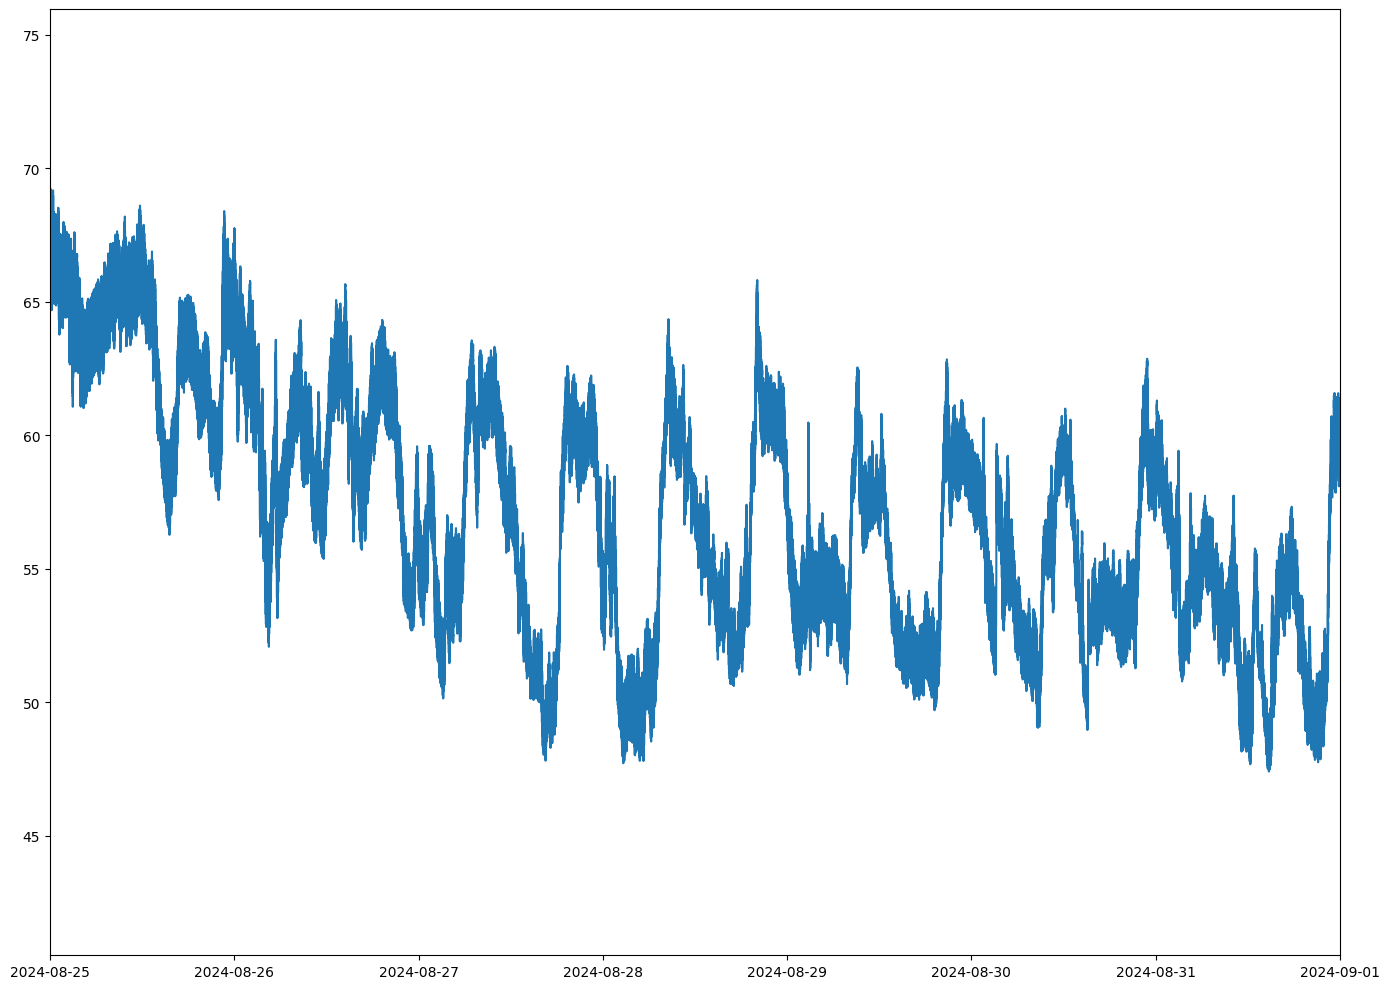

In [116]:
seddddy = calculate_sed_stats(
    waves,
    event_time=dt.datetime(2024, 9, 12, 20, 00),
    event_end = dt.datetime(2024, 9, 19, 00, 00),
    fs=2,
    dtburst=108000,
    overlap=0.3,
    dtens=50400,
)


(4, 50401)
(50401, 1)
(4, 50401) (50401, 4) (50401, 4)


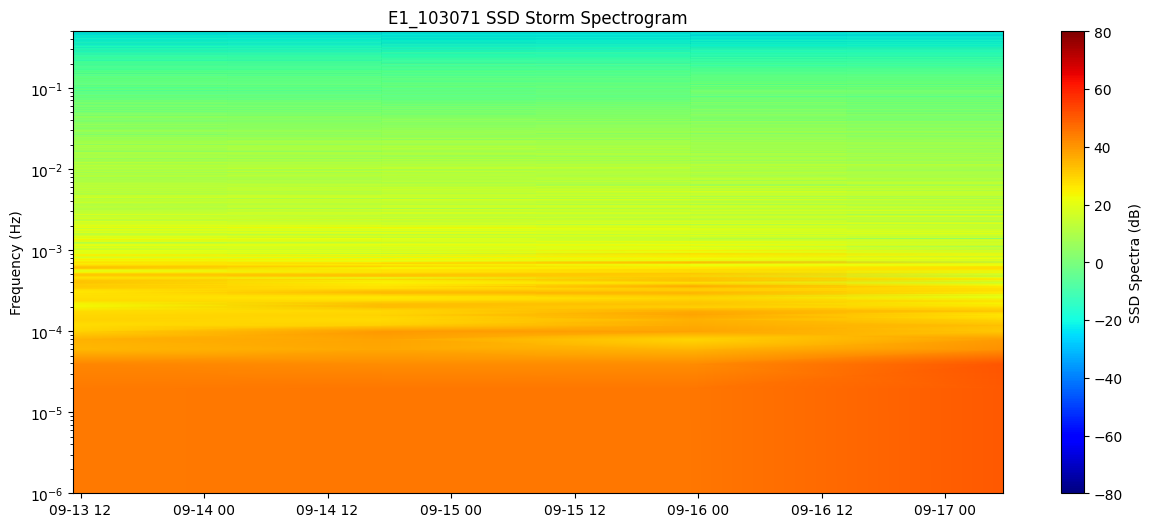

In [117]:
df=seddddy['Storm_psd']
print(df.shape)
df=df.iloc[:,:]

freq_nonan=seddddy['Storm_freq'].fillna(0) # fill NaNs with zeros for plotting
print(freq_nonan.shape)

# create a meshgrid of time and frequency
x,y=np.meshgrid(seddddy['Storm_time'],freq_nonan)
z=df

print(z.shape,x.shape,y.shape)

z_db = 10 * np.log10(z.T)

# Plot Energy Spectra over time per cell
plt.figure(figsize=(15,6))
plt.pcolormesh(
    x,y,z_db, cmap='jet', shading='gouraud', vmin= -80, vmax = 80
)
plt.ylabel("Frequency (Hz)")
plt.title('E1_103071 SSD Storm Spectrogram')
plt.yscale('log')  # Optional: use log-scale if interested in low-frequency tidal signals
plt.ylim(1e-6, 0.5)
im1=plt.colorbar()
im1.ax.set_ylabel("SSD Spectra (dB)")
plt.show()

(18, 50401)
(50401, 1)
(18, 50401) (50401, 18) (50401, 18)


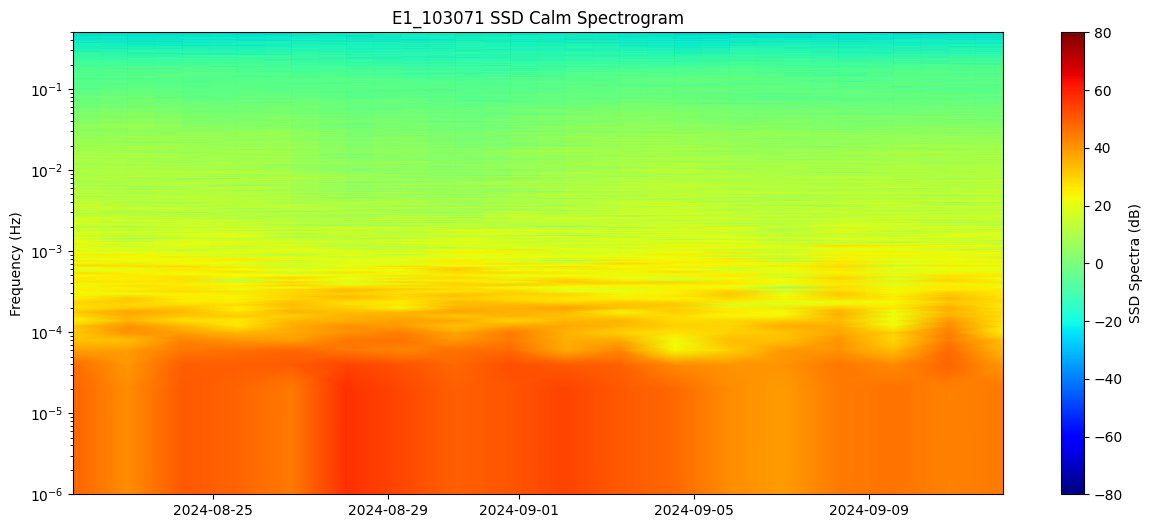

In [118]:
df=seddddy['Calm_psd']
print(df.shape)
df=df.iloc[:,:]

freq_nonan=seddddy['Calm_freq'].fillna(0) # fill NaNs with zeros for plotting
print(freq_nonan.shape)

# create a meshgrid of time and frequency
x,y=np.meshgrid(seddddy['Calm_time'],freq_nonan)
z=df

print(z.shape,x.shape,y.shape)
z_db = 10 * np.log10(z.T)

# Plot Energy Spectra over time per cell
plt.figure(figsize=(15,6))
plt.pcolormesh(
    x,y,z_db, cmap='jet', shading='gouraud', vmin= -80, vmax = 80
)
plt.ylabel("Frequency (Hz)")
plt.title('E1_103071 SSD Calm Spectrogram')
im1=plt.colorbar()
plt.yscale('log')  # Optional: use log-scale if interested in low-frequency tidal signals
plt.ylim(1e-6, 0.5)  # Adjust based on the resolution of your data
im1.ax.set_ylabel("SSD Spectra (dB)")

plt.show()

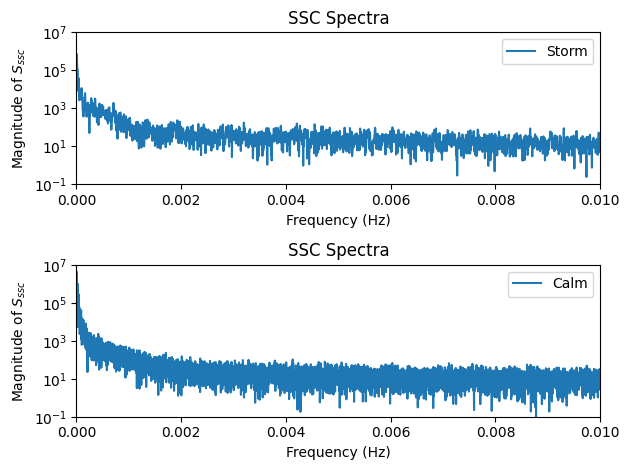

In [119]:
###This code will plot the power spectra agaisnt frequencies
plt.subplot(2,1,1)
plt.semilogy(seddddy['BigFreq2'],seddddy['BigStorm'],label = 'Storm')
plt.title('SSC Spectra')
plt.ylabel('Magnitude of $S_{ssc}$')
plt.xlabel('Frequency (Hz)')
plt.legend(loc = 'upper right')
plt.xlim(0,.01)
plt.ylim(1e-1,1e7)
plt.tight_layout()

plt.subplot(2,1,2)
plt.semilogy(seddddy['BigFreq1'],seddddy['BigCalm'],label = 'Calm')
plt.title('SSC Spectra')
plt.ylabel('Magnitude of $S_{ssc}$')
plt.xlabel('Frequency (Hz)')
plt.legend(loc = 'upper right')
plt.xlim(0,.01)
plt.ylim(1e-1,1e7)
plt.tight_layout()

(1.0, 1000000.0)

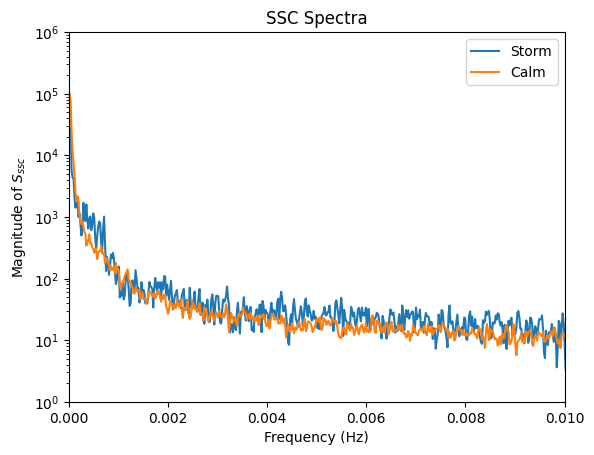

In [120]:
###This code will plot the power spectra agaisnt frequencies
plt.semilogy(seddddy['Storm_freq'],np.nanmean(seddddy['Storm_psd'],axis = 0),label = 'Storm')
plt.semilogy(seddddy['Calm_freq'],np.nanmean(seddddy['Calm_psd'],axis = 0), label = 'Calm')
plt.title('SSC Spectra')
plt.ylabel('Magnitude of $S_{ssc}$')
plt.xlabel('Frequency (Hz)')
plt.legend(loc = 'upper right')
plt.xlim(0,.01)
plt.ylim(1e0,1e6)